In [1]:
import sys
principal_path = '../'
if principal_path not in sys.path:
    sys.path.append('../')

In [2]:
import pandas as pd
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset
import pickle

from models.PlasticityMNISTModel import PlasticityMNISTModel
from models.MNISTModel import MNISTModel
from PruningMLP import PruningMLP
from copy import copy

from utils import *

In [3]:
SEED = 2024
BATCH_SIZE = 32
pl.seed_everything(SEED)

Global seed set to 2024


2024

# [0,1]

In [4]:
checkpoint_ffn = 'checkpoints/mnist_model.ckpt'
model = MNISTModel.load_from_checkpoint(checkpoint_ffn)
model.eval()
print(model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
classes_to_include = [0, 1]
train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data_filtered(BATCH_SIZE, classes_to_include, num_workers=0)

In [6]:
mnist_model_trainer = pl.Trainer(max_epochs=5)
# test model
mnist_model_trainer.test(model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html

Testing DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 71.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8278844356536865
        precision           0.8335698246955872
         recall             0.8226253986358643
        test_acc            0.9825059175491333
        test_loss           0.06702230870723724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.06702230870723724,
  'test_acc': 0.9825059175491333,
  'precision': 0.8335698246955872,
  'recall': 0.8226253986358643,
  'f1': 0.8278844356536865}]

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

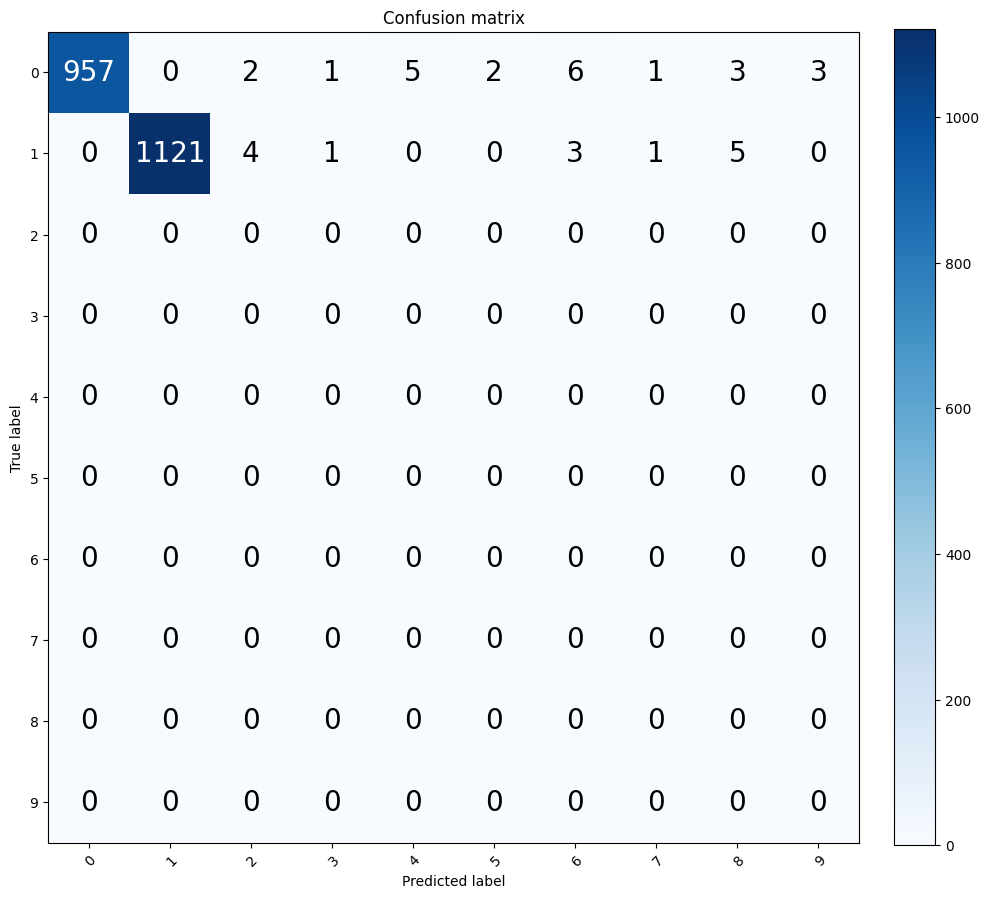

In [7]:
# get predictions
y_true = []
y_pred = []
for batch in test_loader_filtered:
    x, y = batch
    y_true += y.tolist()
    y_pred += model(x).argmax(dim=1).tolist()

# plot confusion matrix
classes = ['0', '1']
plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix')

In [8]:
df = pd.read_csv("activations/activations_minist_model.csv")
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.923480,0.000000,...,-16.595833,-14.188923,-8.905098,-10.092788,-22.101274,-15.535633,-29.975979,-0.000180,-14.806216,-13.204277
1,2.0,0.0,0.00000,2.264030,2.359124,0.000000,1.334890,0.000000,0.821211,0.531313,...,-21.110266,-12.353317,-0.000006,-15.052830,-29.732016,-22.506277,-20.308481,-23.745291,-13.633943,-34.262554
2,1.0,0.0,0.59751,0.420798,0.433036,0.000000,0.574497,1.608488,0.000000,0.053121,...,-15.868408,-0.001101,-9.372239,-12.341898,-9.200323,-9.776160,-9.750698,-8.316074,-7.506509,-14.401055
3,0.0,0.0,0.00000,0.270113,0.000000,1.198138,0.000000,0.000000,2.564893,0.000000,...,-0.000514,-13.230165,-9.013961,-16.788416,-12.716939,-12.957210,-9.124060,-12.553201,-12.449683,-8.221807
4,4.0,0.0,0.00000,0.984886,0.000000,0.000000,0.000000,0.000000,1.628678,0.627652,...,-14.683038,-15.717505,-15.271838,-20.522961,-0.000891,-14.758453,-13.264597,-13.595921,-12.924339,-7.031570


In [9]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

df_layer1 = df[get_layer_columns('Layer1')]
df_layer2 = df[get_layer_columns('Layer2')]
#df_layer3 = df[get_layer_columns('Layer3')]

In [10]:
threshold_layer_1 = 0.5
print(f'Threshold layer 1: {threshold_layer_1*100}%')

mask_indices_layer_1 = find_low_activation_neurons(df_layer1, 0, 1, threshold=threshold_layer_1)
print(f'High activation neurons layer: {128 - len(mask_indices_layer_1)}')

threshold_layer_2 = threshold_layer_1
print(f'Threshold layer 2: {threshold_layer_2*100}%')

mask_indices_layer_2 = find_low_activation_neurons(df_layer2, 0, 1, threshold=threshold_layer_2)

print(f'High activation neurons layer: {256 - len(mask_indices_layer_2)}')

Threshold layer 1: 50.0%
High activation neurons layer: 16
Threshold layer 2: 50.0%
High activation neurons layer: 60


In [11]:
modified_model = copy(model)
print(modified_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [12]:
new_layer_1, new_weights_1, new_bias_1 = remove_neurons_from_layer(modified_model.layer_1, mask_indices_layer_1)
new_layer_2, new_weights_2 = adjust_next_layer(modified_model.layer_2, mask_indices_layer_1)

# Aplica los nuevos pesos y sesgos
modified_model.layer_1 = new_layer_1
modified_model.layer_1.weight.data = new_weights_1
modified_model.layer_1.bias.data = new_bias_1

modified_model.layer_2 = new_layer_2
modified_model.layer_2.weight.data = new_weights_2
# Los sesgos de layer_2 no cambian a menos que también elimines neuronas de layer_2

new_layer_2, new_weights_2, new_bias_2 = remove_neurons_from_layer(modified_model.layer_2, mask_indices_layer_2)

# Aplicar los nuevos pesos y sesgos a layer_2
modified_model.layer_2 = new_layer_2
modified_model.layer_2.weight.data = new_weights_2
modified_model.layer_2.bias.data = new_bias_2

# Ajustar layer_3 en consecuencia
# Supongamos que layer_3 no tiene neuronas eliminadas directamente, pero sus pesos deben ajustarse debido a los cambios en layer_2
new_layer_3, new_weights_3 = adjust_next_layer(modified_model.layer_3, mask_indices_layer_2)

# Aplicar los nuevos pesos a layer_3
modified_model.layer_3 = new_layer_3
modified_model.layer_3.weight.data = new_weights_3

In [13]:
print(modified_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=60, bias=True)
  (layer_3): Linear(in_features=60, out_features=10, bias=True)
)


In [14]:
# test model
mnist_model_trainer.test(modified_model, test_loader_filtered)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 151.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8313480615615845
        precision           0.8392631411552429
         recall              0.825327455997467
        test_acc            0.9687942862510681
        test_loss           0.4815691113471985
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4815691113471985,
  'test_acc': 0.9687942862510681,
  'precision': 0.8392631411552429,
  'recall': 0.825327455997467,
  'f1': 0.8313480615615845}]

In [15]:
# test model
plasticy_model_trainer = pl.Trainer(max_epochs=1)
plasticy_model_trainer.fit(modified_model, train_loader_filtered, val_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | train_acc | MulticlassAccuracy  | 0     
1 | val_acc   | MulticlassAccuracy  | 0     
2 | test_acc  | MulticlassAccuracy  | 0     
3 | precision | MulticlassPrecision | 0     
4 | recall    | MulticlassRecall    | 0     
5 | f1        | MulticlassF1Score   | 0     
6 | layer_1   | Linear              | 12.6 K
7 | layer_2   | Linear              | 1.0 K 
8 | layer_3   | Linear              | 610   
--------------------------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]Failed to save model graph: 'ExperimentWriter' object has no attribute 'add_graph'
Epoch 0: 100%|██████████| 317/317 [00:02<00:00, 142.81it/s, v_num=13, train_loss=0.000568, train_acc=1.000, val_loss=0.00209, val_acc=1.000]

`Trainer.fit` stopped: `max_epochs=1` reached.


Failed to save weights histogram: 'ExperimentWriter' object has no attribute 'add_histogram'
Epoch 0: 100%|██████████| 317/317 [00:02<00:00, 142.56it/s, v_num=13, train_loss=0.000568, train_acc=1.000, val_loss=0.00209, val_acc=1.000]


In [17]:
# test model
plasticy_model_trainer.test(modified_model, test_loader_filtered)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 134.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.9989093542098999
        precision           0.9992865920066833
         recall             0.9986190795898438
        test_acc            0.9990543723106384
        test_loss          0.0030826677102595568
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0030826677102595568,
  'test_acc': 0.9990543723106384,
  'precision': 0.9992865920066833,
  'recall': 0.9986190795898438,
  'f1': 0.9989093542098999}]

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

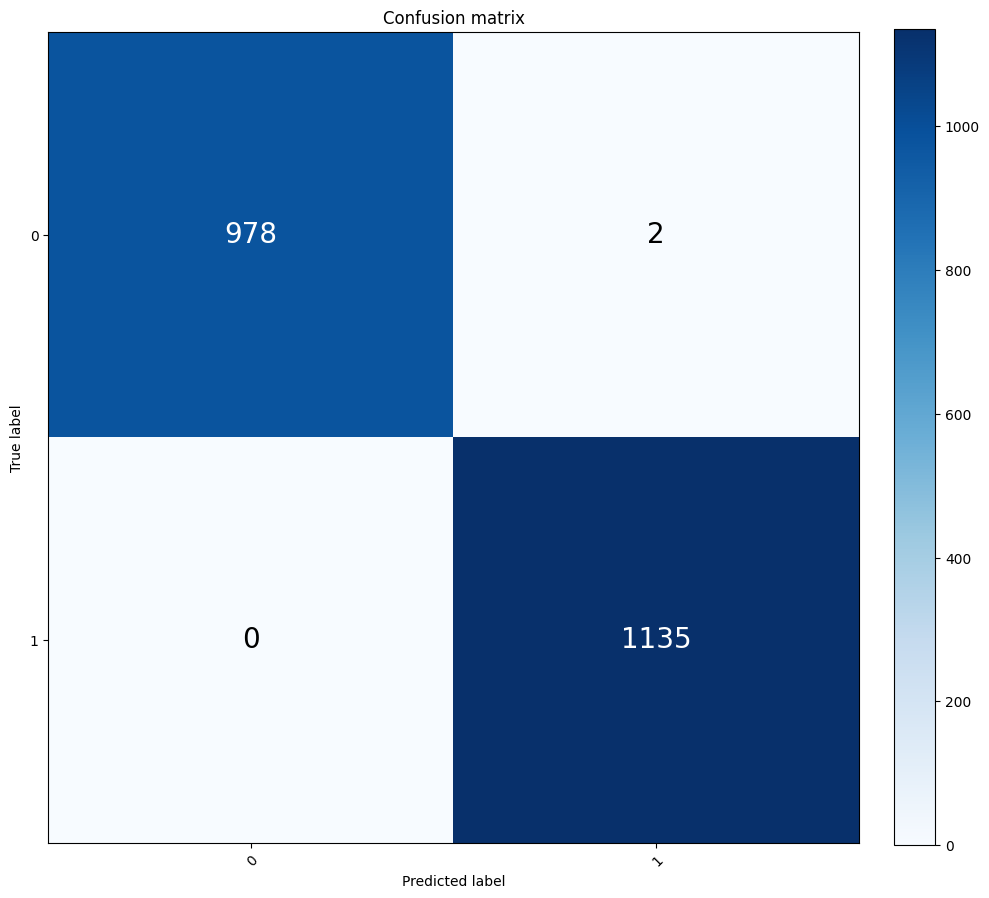

In [18]:
# get predictions
y_true = []
y_pred = []
for batch in test_loader_filtered:
    x, y = batch
    y_true += y.tolist()
    y_pred += modified_model(x).argmax(dim=1).tolist()

# plot confusion matrix
classes = ['0', '1']
plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix')

In [19]:
# save checkpoint
plasticy_model_trainer.save_checkpoint('checkpoints/plasticy_mnist_model.ckpt')

### study weigths

In [20]:
def extract_weights(model):
    layer_1_pls = model.layer_1.weight.data.cpu().numpy()
    layer_2_pls = model.layer_2.weight.data.cpu().numpy()
    layer_3_pls = model.layer_3.weight.data.cpu().numpy()

    return [layer_1_pls, layer_2_pls, layer_3_pls]

In [28]:
# load plasticy model
import torch
import torch.nn as nn
plasticy_model_checkpint = 'checkpoints/plasticy_mnist_model.ckpt'
plasticy_model = MNISTModel()
plasticy_model.layer_1 = nn.Linear(784, 16)
plasticy_model.layer_2 = nn.Linear(16, 60)
plasticy_model.layer_3 = nn.Linear(60, 10)

plasticy_model.on_load_checkpoint(torch.load(plasticy_model_checkpint))
plasticy_model.eval()
print(plasticy_model)


MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=60, bias=True)
  (layer_3): Linear(in_features=60, out_features=10, bias=True)
)


In [29]:
weights_plasticy = extract_weights(plasticy_model)

with open('weights/plasticy_mnist_model_weights.pkl', 'wb') as f:
    pickle.dump(weights_plasticy, f)

In [30]:
#load minist model
mnist_model = MNISTModel.load_from_checkpoint(checkpoint_ffn)
mnist_model.eval()
print(mnist_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [31]:
weights_mnist = extract_weights(mnist_model)

with open('weights/mnist_model_weights.pkl', 'wb') as f:
    pickle.dump(weights_mnist, f)

In [90]:
import torch

# Supongamos que tienes los modelos original_model y modified_model ya definidos y entrenados
# Vamos a calcular algunas estadísticas básicas de los pesos de la primera capa de ambos modelos

# Función para calcular estadísticas de los pesos


original_layer_1_stats = weight_statistics(mnist_model, 'layer_1')
modified_layer_1_stats = weight_statistics(plasticy_model, 'layer_1')

print("Original layer 1 stats:")
print(original_layer_1_stats)
print("Modified layer 1 stats:")
print(modified_layer_1_stats)


Original layer 1 stats:
{'mean': -0.0031360266730189323, 'std_dev': 0.06922026723623276, 'max': 0.3438122570514679, 'min': -0.6698693037033081}
Modified layer 1 stats:
{'mean': 0.0003164679801557213, 'std_dev': 0.020635632798075676, 'max': 0.03570001944899559, 'min': -0.03569503128528595}


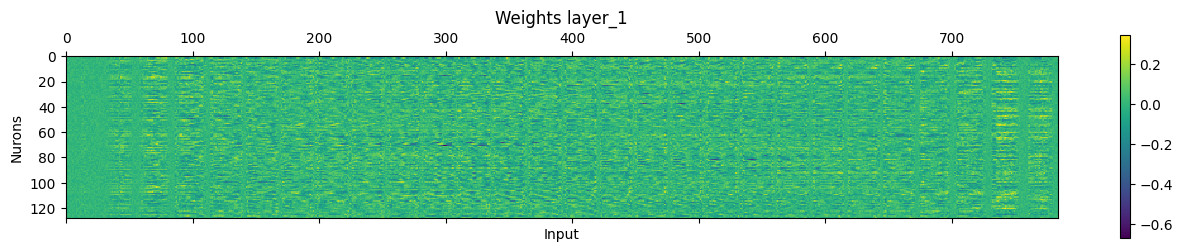

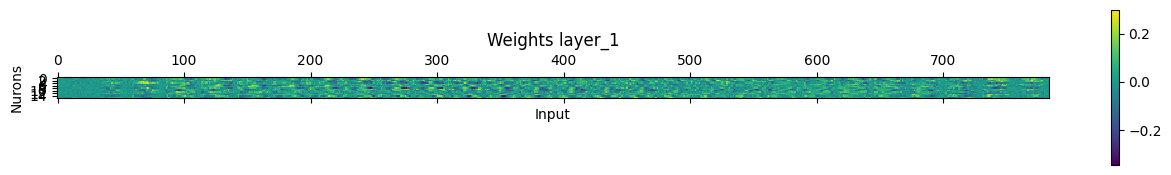

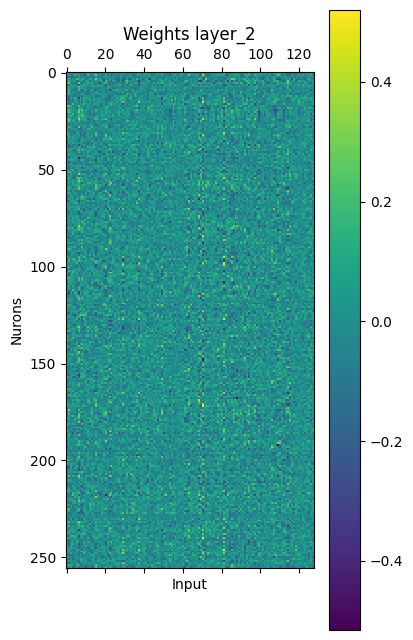

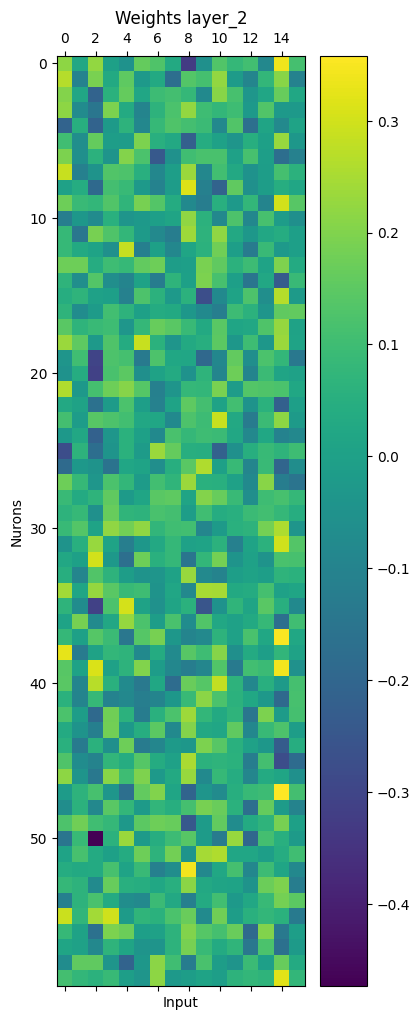

In [91]:
import matplotlib.pyplot as plt

# Visualizar los pesos de la primera capa de ambos modelos
plot_weights(mnist_model, 'layer_1')
plot_weights(modified_model, 'layer_1')

# Visualizar los pesos de la segunda capa de ambos modelos
plot_weights(mnist_model, 'layer_2')
plot_weights(modified_model, 'layer_2')



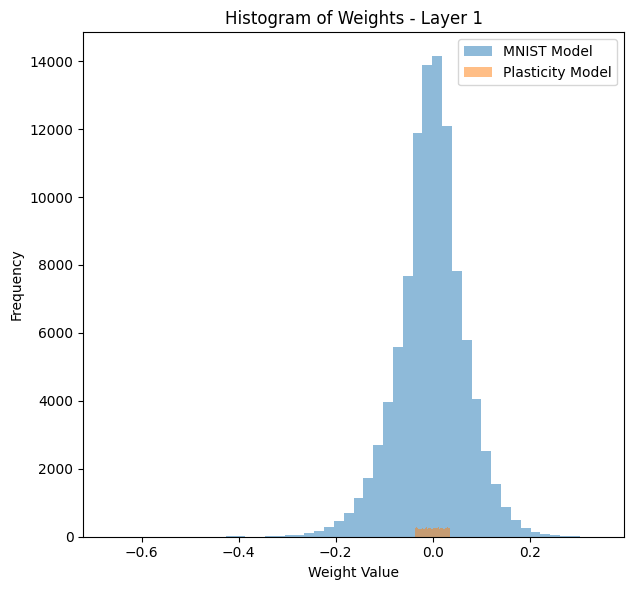

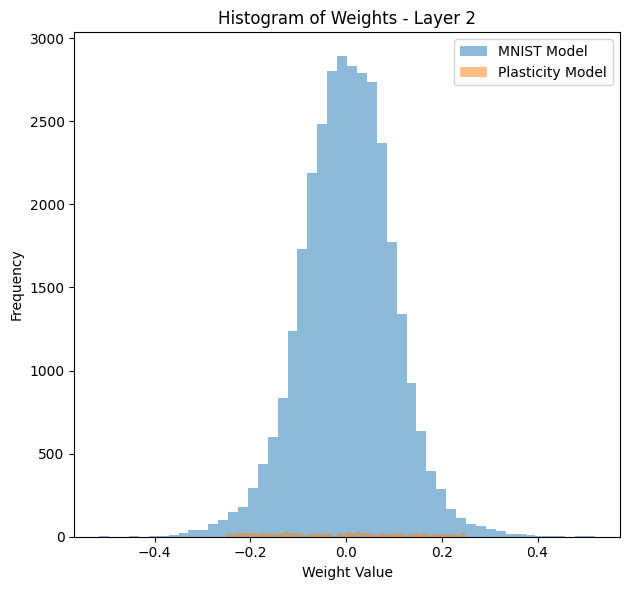

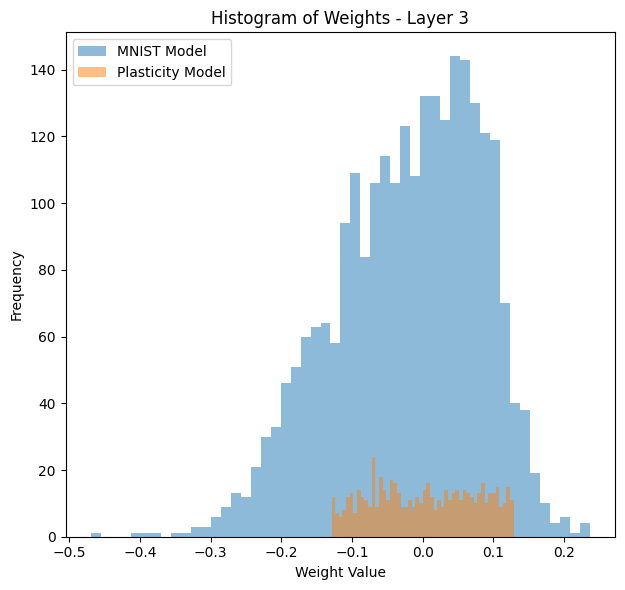

In [32]:
import matplotlib.pyplot as plt

# Function to plot histograms for each layer


# Plot histograms for each layer
for i in range(3):
    plot_weight_histograms(weights_mnist, weights_plasticy, i, label1='MNIST Model', label2='Plasticity Model')


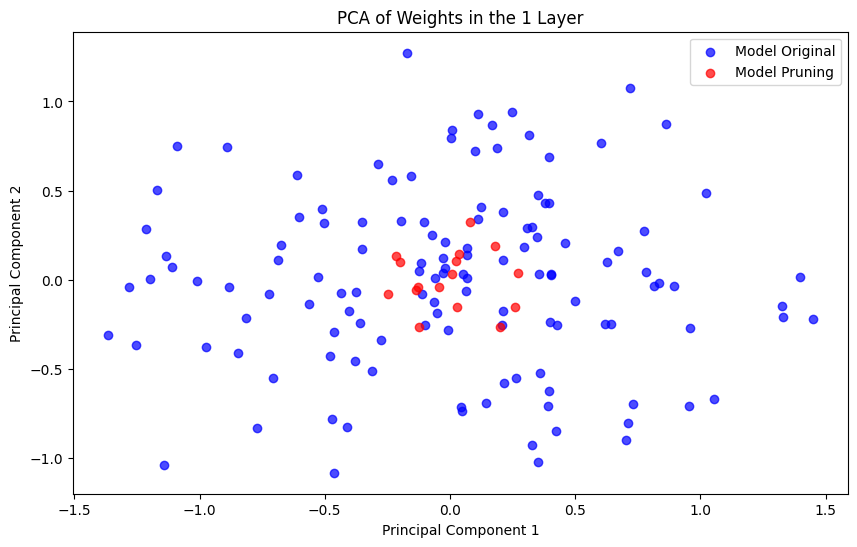

In [82]:
plot_pca(weights_mnist, weights_plasticy, 0)

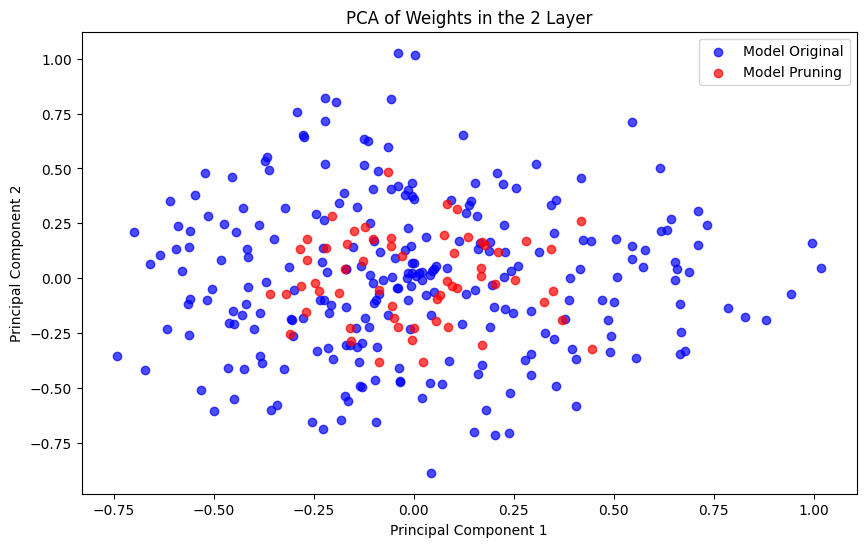

In [83]:
plot_pca(weights_mnist, weights_plasticy, 1)

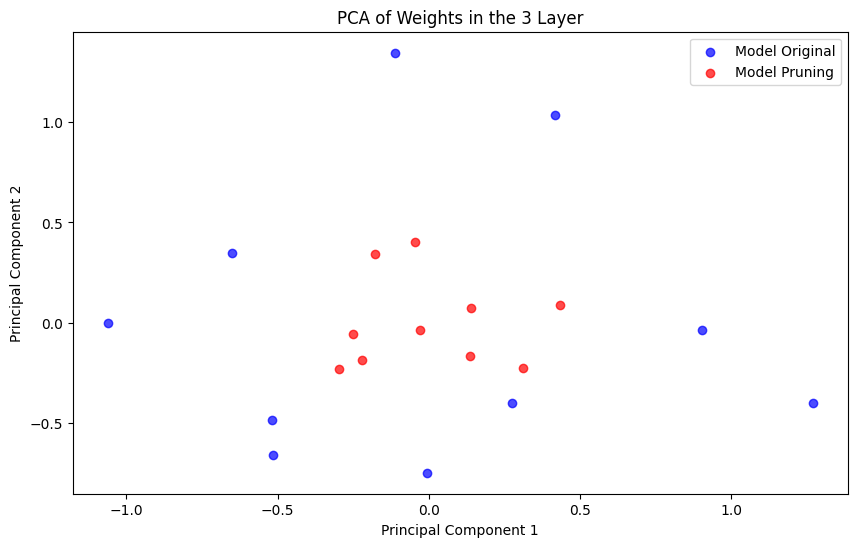

In [85]:
plot_pca(weights_mnist, weights_plasticy, 2)

# [0,2,4,6,8] [1,3,5,7,9]

## Even Numbers

In [4]:
checkpoint_ffn = 'checkpoints/mnist_model.ckpt'
model = MNISTModel.load_from_checkpoint(checkpoint_ffn)
model.eval()
print(model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(


In [4]:
even_numbers = [0,2,4,6,8]
train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data_filtered(BATCH_SIZE, even_numbers, num_workers=0)

In [6]:
mnist_model_trainer = pl.Trainer(max_epochs=5)
# test model
mnist_model_trainer.test(model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.4796672761440277     │
│         precision         │    0.4882674813270569     │
│          recall           │    0.4750726819038391     │
│         test_acc          │    0.9531059861183167     │
│         test_loss         │    0.1601257622241974     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1601257622241974,
  'test_acc': 0.9531059861183167,
  'precision': 0.4882674813270569,
  'recall': 0.4750726819038391,
  'f1': 0.4796672761440277}]

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

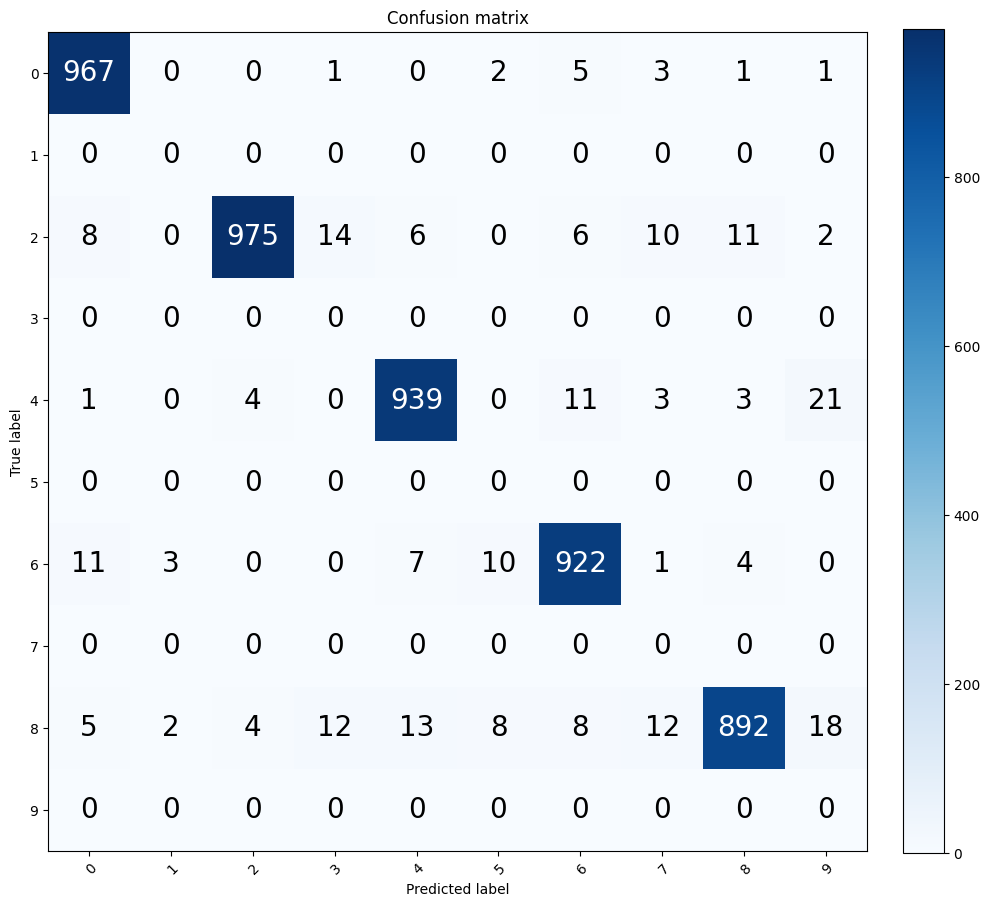

In [7]:
# get predictions
y_true = []
y_pred = []
for batch in test_loader_filtered:
    x, y = batch
    y_true += y.tolist()
    y_pred += model(x).argmax(dim=1).tolist()

# plot confusion matrix
classes = None
plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix')

In [8]:
df = pd.read_csv("activations/activations_minist_model.csv")
df.head()

,Number,layer_1_Neuron1,layer_1_Neuron2,layer_1_Neuron3,layer_1_Neuron4,layer_1_Neuron5,layer_1_Neuron6,layer_1_Neuron7,layer_1_Neuron8,layer_1_Neuron9,...,layer_3_Neuron1,layer_3_Neuron2,layer_3_Neuron3,layer_3_Neuron4,layer_3_Neuron5,layer_3_Neuron6,layer_3_Neuron7,layer_3_Neuron8,layer_3_Neuron9,layer_3_Neuron10
0,7.0,0.449542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-12.147557,-16.156612,-7.710542,-7.271403,-16.029039,-11.763829,-21.846853,-0.001201,-14.597518,-10.055030
1,2.0,1.981847,0.000000,2.332592,2.098222,0.138524,1.114918,0.000000,0.000000,0.376550,...,-10.453403,-7.174742,-0.005843,-5.811386,-15.197481,-7.710470,-7.108836,-16.036266,-7.167393,-18.166189
2,1.0,0.556063,0.000000,0.702207,1.305601,0.000000,0.185222,1.902156,0.000000,0.096356,...,-10.221011,-0.015790,-6.059709,-7.541844,-6.083756,-7.373065,-6.179751,-5.144793,-6.342128,-8.537990
3,0.0,0.000000,0.000000,0.922271,0.000000,1.780782,0.000000,0.000000,0.000000,0.516040,...,-0.000767,-17.257816,-7.764552,-10.846606,-12.649820,-9.893708,-9.928405,-10.246428,-11.425212,-8.658000
4,4.0,0.000000,0.930661,1.347643,0.000000,0.000000,0.000000,0.000000,0.907871,1.582013,...,-7.864855,-13.278628,-7.676012,-10.088933,-0.017552,-7.109054,-8.037715,-5.901061,-7.700401,-4.408139


In [12]:
pruning_MLP = PruningMLP(even_numbers)
model_pruned = pruning_MLP.prune(model, df, {'layer_1': 0.9, 'layer_2': 0.9})
print(model_pruned)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=4, bias=True)
  (layer_2): Linear(in_features=4, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
)


In [13]:
# trainer
mod_model_trainer = pl.Trainer(max_epochs=5)
# test model
mod_model_trainer.test(model_pruned, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │   0.032817140221595764    │
│         precision         │   0.019935037940740585    │
│          recall           │    0.10000014305114746    │
│         test_acc          │    0.19935038685798645    │
│         test_loss         │     2.351743221282959     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.351743221282959,
  'test_acc': 0.19935038685798645,
  'precision': 0.019935037940740585,
  'recall': 0.10000014305114746,
  'f1': 0.032817140221595764}]

In [15]:
# train
mod_model_trainer.fit(model_pruned, train_loader_filtered, val_loader_filtered)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | train_acc | MulticlassAccuracy  | 0     
1 | val_acc   | MulticlassAccuracy  | 0     
2 | test_acc  | MulticlassAccuracy  | 0     
3 | precision | MulticlassPrecision | 0     
4 | recall    | MulticlassRecall    | 0     
5 | f1        | MulticlassF1Score   | 0     
6 | layer_1   | Linear              | 3.1 K 
7 | layer_2   | Linear              | 50    
8 | layer_3   | Linear              | 110   
--------------------------------------------------
3.3 K     Trainable params
0  

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [17]:
# test model
mod_model_trainer.test(model_pruned, test_loader_filtered)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.47750982642173767    │
│         precision         │    0.4797831177711487     │
│          recall           │     0.479098379611969     │
│         test_acc          │    0.9602110981941223     │
│         test_loss         │    0.14354512095451355    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.14354512095451355,
  'test_acc': 0.9602110981941223,
  'precision': 0.4797831177711487,
  'recall': 0.479098379611969,
  'f1': 0.47750982642173767}]

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

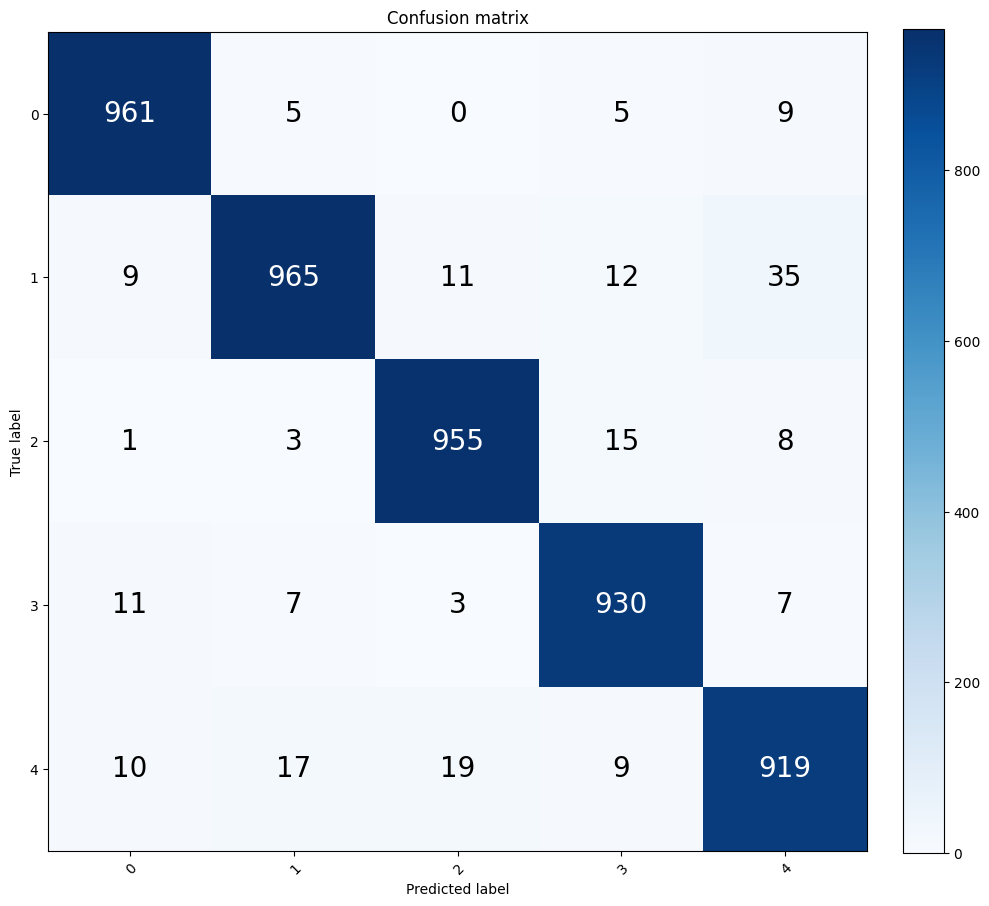

In [19]:
# get predictions
y_true = []
y_pred = []
for batch in test_loader_filtered:
    x, y = batch
    y_true += y.tolist()
    y_pred += model_pruned(x).argmax(dim=1).tolist()

# plot confusion matrix
classes = None
plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix')

### BottelNet

In [5]:
from models.MNISTModelWithBottelNeck import MNISTModelWithBottelNeck


bottelnet_checkpoint = 'checkpoints/mnist_model_bottel_neck.ckpt'
model_bottelnet = MNISTModelWithBottelNeck.load_from_checkpoint(bottelnet_checkpoint)
model_bottelnet.eval()
print(model_bottelnet)

MNISTModelWithBottelNeck(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=784, bias=True)
  (layer_3): Linear(in_features=784, out_features=10, bias=True)
)


In [6]:
# test
bottelnet_model_trainer = pl.Trainer(max_epochs=5)
bottelnet_model_trainer.test(model_bottelnet, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.4850616753101349     │
│         precision         │    0.4912668466567993     │
│          recall           │    0.4818003177642822     │
│         test_acc          │    0.9648802280426025     │
│         test_loss         │    0.11057160049676895    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11057160049676895,
  'test_acc': 0.9648802280426025,
  'precision': 0.4912668466567993,
  'recall': 0.4818003177642822,
  'f1': 0.4850616753101349}]

In [8]:
df = pd.read_csv("activations/activations_minist_model_bottel_neck.csv")
df.head()

,Number,layer_1_Neuron1,layer_1_Neuron2,layer_1_Neuron3,layer_1_Neuron4,layer_1_Neuron5,layer_1_Neuron6,layer_1_Neuron7,layer_1_Neuron8,layer_1_Neuron9,...,layer_3_Neuron1,layer_3_Neuron2,layer_3_Neuron3,layer_3_Neuron4,layer_3_Neuron5,layer_3_Neuron6,layer_3_Neuron7,layer_3_Neuron8,layer_3_Neuron9,layer_3_Neuron10
0,7.0,0.263696,0.000000,0.00000,0.000000,0.141333,0.000000,0.000000,0.285032,0.000000,...,-15.224203,-12.899465,-7.787680,-5.763442,-16.093821,-12.746031,-23.097193,-0.004110,-14.059266,-7.524554
1,2.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.596677,1.227557,1.123563,0.497353,...,-10.328734,-6.156970,-0.002433,-8.562925,-17.386738,-11.050374,-10.695917,-15.268203,-9.936504,-19.288153
2,1.0,0.644008,0.217488,0.00000,0.049021,0.000000,0.514683,0.404544,0.000000,0.026223,...,-9.683863,-0.014177,-6.245885,-8.168837,-5.740150,-8.440497,-7.465419,-5.103272,-6.443178,-9.007465
3,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.648394,0.000000,1.429647,0.000000,...,-0.001296,-12.824494,-8.546868,-11.030286,-10.846011,-9.230650,-8.384238,-9.249350,-10.858867,-7.384430
4,4.0,0.000000,0.000000,0.06545,0.255205,0.000000,0.000000,0.000000,0.000000,0.376863,...,-10.019976,-11.619699,-9.525784,-10.673840,-0.206108,-9.737457,-9.422080,-5.411996,-8.526304,-1.707576


In [9]:
pruning_MLP = PruningMLP(even_numbers)
model_bottelnet_pruned = pruning_MLP.prune(model_bottelnet, df, {'layer_1': 0.5})
print(model_bottelnet_pruned)

MNISTModelWithBottelNeck(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=57, bias=True)
  (layer_2): Linear(in_features=57, out_features=784, bias=True)
  (layer_3): Linear(in_features=784, out_features=10, bias=True)
)


In [10]:
mnist_model_trainer = pl.Trainer(max_epochs=5)
# test model
mnist_model_trainer.test(model_bottelnet_pruned, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.4620376229286194     │
│         precision         │    0.4696666896343231     │
│          recall           │    0.46454891562461853    │
│         test_acc          │    0.9295574426651001     │
│         test_loss         │    0.29921528697013855    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.29921528697013855,
  'test_acc': 0.9295574426651001,
  'precision': 0.4696666896343231,
  'recall': 0.46454891562461853,
  'f1': 0.4620376229286194}]

In [11]:
mnist_model_trainer = pl.Trainer(max_epochs=5)
# test model
mnist_model_trainer.fit(model_bottelnet_pruned, train_loader_filtered, val_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | train_acc | MulticlassAccuracy  | 0     
1 | val_acc   | MulticlassAccuracy  | 0     
2 | test_acc  | MulticlassAccuracy  | 0     
3 | precision | MulticlassPrecision | 0     
4 | recall    | MulticlassRecall    | 0     
5 | f1        | MulticlassF1Score   | 0     
6 | layer_1   | Linear              | 44.7 K
7 | layer_2   | Linear              | 45.5 K
8 | layer_3   | Linear              | 7.9 K 
--------------------------------------------------
98.1 K    Trainable params
0         Non-trainable params
98.1 K    Total params
0.392     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [12]:
# test model
mnist_model_trainer.test(model_bottelnet_pruned, test_loader_filtered)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.4880332052707672     │
│         precision         │     0.489257276058197     │
│          recall           │    0.4887339472770691     │
│         test_acc          │    0.9801055788993835     │
│         test_loss         │    0.07979635149240494    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07979635149240494,
  'test_acc': 0.9801055788993835,
  'precision': 0.489257276058197,
  'recall': 0.4887339472770691,
  'f1': 0.4880332052707672}]

## Odd numbers

In [146]:
odd_numbers = [1,3,5,7,9]

train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data_filtered(BATCH_SIZE, odd_numbers, num_workers=0)

In [147]:
minist_model = MNISTModel.load_from_checkpoint(checkpoint_ffn)
minist_model.eval()

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)

In [148]:
# test
mnist_model_trainer = pl.Trainer(max_epochs=5)
mnist_model_trainer.test(minist_model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 159/159 [00:01<00:00, 143.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8576943874359131
        precision           0.8713141083717346
         recall             0.8510560989379883
        test_acc            0.9507291913032532
        test_loss           0.15340262651443481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15340262651443481,
  'test_acc': 0.9507291913032532,
  'precision': 0.8713141083717346,
  'recall': 0.8510560989379883,
  'f1': 0.8576943874359131}]

In [149]:
df = pd.read_csv("activations/activations_minist_model.csv")
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.449542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-12.147556,-16.156610,-7.710541,-7.271402,-16.029039,-11.763827,-21.846853,-0.001201,-14.597517,-10.055029
1,2.0,1.981847,0.000000,2.332592,2.098222,0.138524,1.114918,0.000000,0.000000,0.376550,...,-10.453403,-7.174742,-0.005843,-5.811386,-15.197481,-7.710469,-7.108836,-16.036268,-7.167393,-18.166189
2,1.0,0.556063,0.000000,0.702207,1.305601,0.000000,0.185222,1.902156,0.000000,0.096356,...,-10.221011,-0.015790,-6.059708,-7.541843,-6.083756,-7.373065,-6.179750,-5.144792,-6.342128,-8.537989
3,0.0,0.000000,0.000000,0.922271,0.000000,1.780782,0.000000,0.000000,0.000000,0.516040,...,-0.000767,-17.257816,-7.764553,-10.846607,-12.649820,-9.893709,-9.928406,-10.246429,-11.425213,-8.658001
4,4.0,0.000000,0.930661,1.347643,0.000000,0.000000,0.000000,0.000000,0.907871,1.582013,...,-7.864855,-13.278628,-7.676012,-10.088933,-0.017552,-7.109054,-8.037715,-5.901061,-7.700401,-4.408139


In [150]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

df_layer1 = df[get_layer_columns('Layer1')]
df_layer2 = df[get_layer_columns('Layer2')]

In [151]:
threshold_layer_1 = 0.5
print(f'Threshold layer 1: {threshold_layer_1*100}%')

mask_indices_layer_1 = find_low_activation_neurons_2(df_layer1, odd_numbers, threshold=threshold_layer_1)
print(f'High activation neurons layer: {128 - len(mask_indices_layer_1)}')

threshold_layer_2 = threshold_layer_1
print(f'Threshold layer 2: {threshold_layer_2*100}%')

mask_indices_layer_2 = find_low_activation_neurons_2(df_layer2, odd_numbers, threshold=threshold_layer_2)

print(f'High activation neurons layer: {256 - len(mask_indices_layer_2)}')

Threshold layer 1: 50.0%
High activation neurons layer: 75
Threshold layer 2: 50.0%
High activation neurons layer: 146


In [152]:
modified_model = copy(minist_model)
print(modified_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
)


In [153]:
new_layer_1, new_weights_1, new_bias_1 = remove_neurons_from_layer(modified_model.layer_1, mask_indices_layer_1)
new_layer_2, new_weights_2 = adjust_next_layer(modified_model.layer_2, mask_indices_layer_1)

# Aplica los nuevos pesos y sesgos
modified_model.layer_1 = new_layer_1
modified_model.layer_1.weight.data = new_weights_1
modified_model.layer_1.bias.data = new_bias_1

modified_model.layer_2 = new_layer_2
modified_model.layer_2.weight.data = new_weights_2
# Los sesgos de layer_2 no cambian a menos que también elimines neuronas de layer_2

new_layer_2, new_weights_2, new_bias_2 = remove_neurons_from_layer(modified_model.layer_2, mask_indices_layer_2)

# Aplicar los nuevos pesos y sesgos a layer_2
modified_model.layer_2 = new_layer_2
modified_model.layer_2.weight.data = new_weights_2
modified_model.layer_2.bias.data = new_bias_2

# Ajustar layer_3 en consecuencia
# Supongamos que layer_3 no tiene neuronas eliminadas directamente, pero sus pesos deben ajustarse debido a los cambios en layer_2
new_layer_3, new_weights_3 = adjust_next_layer(modified_model.layer_3, mask_indices_layer_2)

# Aplicar los nuevos pesos a layer_3
modified_model.layer_3 = new_layer_3
modified_model.layer_3.weight.data = new_weights_3

In [154]:
print(modified_model)

MNISTModel(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
  (layer_1): Linear(in_features=784, out_features=75, bias=True)
  (layer_2): Linear(in_features=75, out_features=146, bias=True)
  (layer_3): Linear(in_features=146, out_features=10, bias=True)
)


In [155]:
# trainer
mod_model_trainer = pl.Trainer(max_epochs=5)
# test model
mod_model_trainer.test(modified_model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 159/159 [00:01<00:00, 145.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.8697372674942017
        precision           0.8916323781013489
         recall             0.8699097037315369
        test_acc             0.919393002986908
        test_loss           0.30572226643562317
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.30572226643562317,
  'test_acc': 0.919393002986908,
  'precision': 0.8916323781013489,
  'recall': 0.8699097037315369,
  'f1': 0.8697372674942017}]

In [156]:
mod_model_trainer.fit(modified_model, train_loader_filtered, val_loader_filtered)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | train_acc | MulticlassAccuracy  | 0     
1 | val_acc   | MulticlassAccuracy  | 0     
2 | test_acc  | MulticlassAccuracy  | 0     
3 | precision | MulticlassPrecision | 0     
4 | recall    | MulticlassRecall    | 0     
5 | f1        | MulticlassF1Score   | 0     
6 | layer_1   | Linear              | 58.9 K
7 | layer_2   | Linear              | 11.1 K
8 | layer_3   | Linear              | 1.5 K 
--------------------------------------------------
71.4 K    Trainable params
0         Non-trainable params
71.4 K    Total params
0.286     Total estimated model params size (MB)


c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\code\ExAI\exai\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]Failed to save model graph: 'ExperimentWriter' object has no attribute 'add_graph'
Epoch 4: 100%|██████████| 763/763 [00:05<00:00, 148.21it/s, v_num=22, train_loss=0.0132, train_acc=1.000, val_loss=0.0824, val_acc=0.976]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Failed to save weights histogram: 'ExperimentWriter' object has no attribute 'add_histogram'
Epoch 4: 100%|██████████| 763/763 [00:05<00:00, 148.03it/s, v_num=22, train_loss=0.0132, train_acc=1.000, val_loss=0.0824, val_acc=0.976]


In [157]:
# test model
mod_model_trainer.test(modified_model, test_loader_filtered)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 159/159 [00:01<00:00, 151.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.9821791648864746
        precision           0.9834767580032349
         recall             0.9842404723167419
        test_acc            0.9840362668037415
        test_loss           0.05598755180835724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.05598755180835724,
  'test_acc': 0.9840362668037415,
  'precision': 0.9834767580032349,
  'recall': 0.9842404723167419,
  'f1': 0.9821791648864746}]